In [39]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from scipy.special import digamma, gamma, logsumexp

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set()

In [251]:
def run_inference(X, max_iter=50):
    
    Nobs, Ndim = X.shape

    Ncomp = 6
    m0 = np.zeros(Ndim) + 0
    alpha0 = np.zeros(Ncomp) + 1/Ncomp
    beta0 = 1.
    nu0 = Ndim
    W0 = np.eye(Ndim)

    Nk = Nobs / Ncomp + np.zeros(Ncomp)
    beta = beta0 + Nk
    alpha = alpha0 + Nk
    nu = nu0 + Nk
    indices = np.random.choice(Nobs, Ncomp, replace=False)
    mu = np.zeros((Ncomp, Ndim))
    mu[:] = X[indices]
    W = np.tile(W0, (Ncomp, 1, 1))
    
    old_param = np.concatenate((alpha, beta, mu.flatten(), W.flatten(), nu))
    
    for i in range(max_iter):

        # Expectation
        d = X[:, None, :] - mu
        no_name = -0.5 * (
            Ndim/beta 
            + nu * np.sum(
                np.einsum("kij,nkj->nki", W, d) * d, axis=-1))
        ln_pi = digamma(alpha) - digamma(alpha.sum())
        ln_Lambda = digamma(0.5 * (nu - np.arange(Ndim)[:, None])).sum(axis=0) \
            + Ndim * np.log(2) + np.linalg.slogdet(W)[1]
        ln_r = ln_pi + 0.5 * ln_Lambda + no_name
        ln_r -= logsumexp(ln_r, axis=-1)[:, None]
        r = np.exp(ln_r)

        # Maximization
        Nk = r.sum(axis=0) + np.finfo(float).eps
        Xm = (X.T.dot(r) / Nk).T
        d = X[:, None, :] - Xm
        S = np.einsum('nki,nkj->kij', d, r[:, :, None] * d) / Nk[:, None, None]
        alpha = alpha0 + Nk
        beta = beta0 + Nk
        mu = (beta0 * m0 + Nk[:, None] * Xm) / beta[:, None]
        d = Xm - m0
        W = np.linalg.inv(
            np.linalg.inv(W0)
            + (Nk * S.T).T
            + (beta0 * Nk * np.einsum('ki,kj->kij', d, d).T / (beta0 + Nk)).T)
        nu = nu0 + Nk
        
        param = np.concatenate((alpha, beta, mu.flatten(), W.flatten(), nu))
        if np.allclose(param, old_param):
            print(f"converge in {i+1} iterations")
            break
        old_param = param
        

    return alpha, beta, mu, W, nu

In [252]:
def student_t(x, alpha, beta, mu, W, nu):
    _nu_ = nu + 1 - Ndim
    L = (_nu_ * beta * W.T / (1 + beta)).T
    d = x[:, None, :] - mu
    maha_sq = np.sum(np.einsum('nki,kij->nkj', d, L) * d, axis=-1)
    return (
        gamma(0.5 * (_nu_ + Ndim))
        * np.sqrt(np.linalg.det(L))
        * (1 + maha_sq / _nu_) ** (-0.5 * (_nu_ + Ndim))
        / (gamma(0.5 * _nu_) * (_nu_ * np.pi) ** (0.5 * Ndim)))

def pdf(x, alpha, beta, mu, W, nu):
    return (alpha * student_t(x=x, alpha=alpha, beta=beta, mu=mu, W=W, nu=nu)).sum(axis=-1) / alpha.sum()

# Synthetic dataset

In [253]:
np.random.seed(1234)

In [254]:
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

In [255]:
alpha, beta, mu, W, nu = run_inference(x_train)

converge in 33 iterations


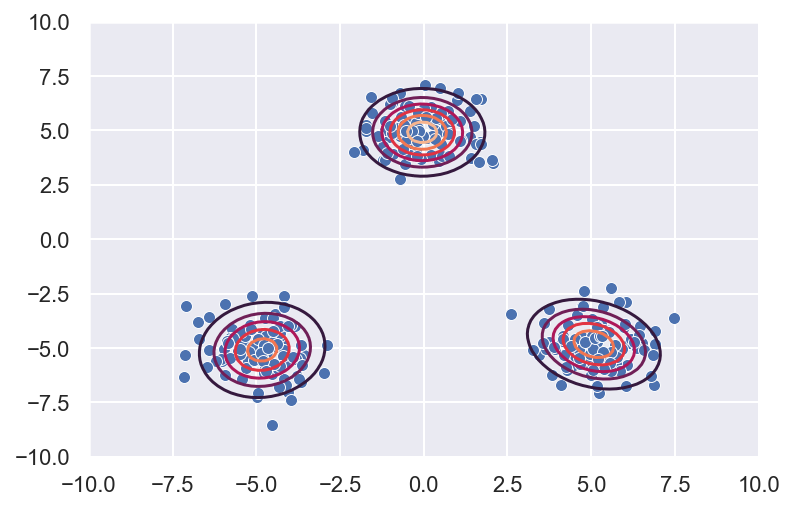

In [256]:
fig, ax = plt.subplots()
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], ax=ax)

x0, x1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x = np.array([x0, x1]).reshape(2, -1).T
ax.contour(x0, x1, pdf(x=x, alpha=alpha, beta=beta, mu=mu, W=W, nu=nu).reshape(100, 100));

# Old Faithful dataset

In [257]:
df = pd.read_csv('faithful.csv', index_col=0)
df

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85
...,...,...
268,4.117,81
269,2.150,46
270,4.417,90
271,1.817,46


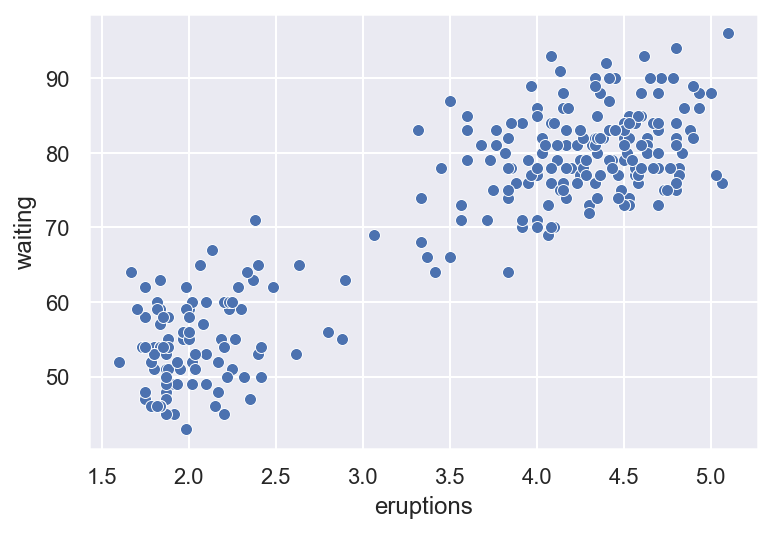

In [261]:
sns.scatterplot(x='eruptions', y='waiting', data=df);

In [262]:
X = np.vstack((df.eruptions, df.waiting)).T
alpha, beta, mu, W, nu = run_inference(X)

converge in 16 iterations


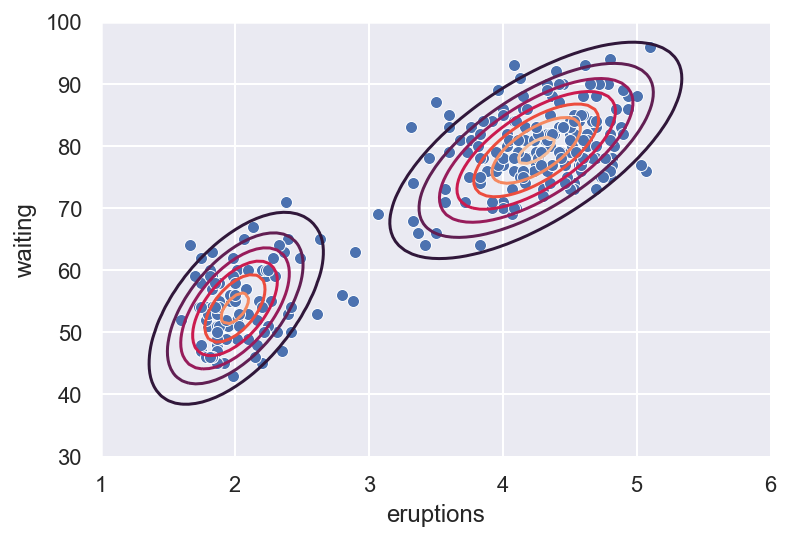

In [268]:
fig, ax = plt.subplots()
sns.scatterplot(x='eruptions', y='waiting', data=df, ax=ax)

x0, x1 = np.meshgrid(np.linspace(1, 6, 100), np.linspace(30, 100, 100))
x = np.array([x0, x1]).reshape(2, -1).T
ax.contour(x0, x1, pdf(x=x, alpha=alpha, beta=beta, mu=mu, W=W, nu=nu).reshape(100, 100))
# ax.set_aspect((6-1)/(100-30));